In [ ]:
# default_exp las

# Las

> Basic functionalities to work and process point cloud (LAS/LAZ) files

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import laspy
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import os
import random
import re
from tqdm import tqdm
tqdm.pandas()
from fastcore.test import *

/opt/conda/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
data_path = Path('../../../andras/ml/AV_leafon/AV_las/')
files = os.listdir(data_path)
example = random.sample(files, 1)[0]


LiDAR data for tabular models, used features from T. Tanhuanpää

In [ ]:
#export

def las_to_df(fn:str) -> pd.DataFrame:
    "Open .las-file and return it as dataframe with columns [x, y, z, num_returns, intensity]"
    lasfile = laspy.file.File(fn, mode='r')
    lidar_df = pd.DataFrame(columns=['x', 'y', 'z', 'num_returns', 'intensity'],
                            data=np.dstack((lasfile.x, lasfile.y, lasfile.z, lasfile.intensity, lasfile.num_returns))[0])
    lasfile.close()
    return lidar_df

def field_plot_circular(lidar_df:pd.DataFrame, plot_x:float, plot_y:float, radius:float=9) -> pd.DataFrame:
    "Select only the circular field plot area as valid lidar data"
    lidar_df = lidar_df[lidar_df.apply(lambda row:np.linalg.norm(np.array([row.x, row.y]).T - np.array([plot_x, plot_y]).T) <= 9, axis=1)]
    return lidar_df
                            
def calc_metrics(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    "Calculate typical LiDAR-metrics from dataframe containing lidar information"
    vege_df = lidar_df[lidar_df.z >= min_h]
    if len(vege_df) == 0: return None
    
    # Simple metrics
    hmax = vege_df.z.max() # maximum height
    hmean = vege_df.z.mean() # mean height
    hstd  = vege_df.z.std() # standard deviation for height
    pene = len(vege_df) / len(lidar_df) # penetration percentage
    cv = hstd / hmean # coefficient of variation
    imax = vege_df.intensity.max() # maximum intensity
    imean = vege_df.intensity.mean() # mean intensity
    imedian = vege_df.intensity.median() # median intensity
    
    # Height quantiles for returns above minimum height
    h10 = vege_df.z.quantile(0.1)
    h20 = vege_df.z.quantile(0.2)
    h30 = vege_df.z.quantile(0.3)
    h40 = vege_df.z.quantile(0.4)
    h50 = vege_df.z.quantile(0.5)
    h60 = vege_df.z.quantile(0.6)
    h70 = vege_df.z.quantile(0.7)
    h80 = vege_df.z.quantile(0.8)
    h90 = vege_df.z.quantile(0.9)
    h95 = vege_df.z.quantile(0.95)
    h98 = vege_df.z.quantile(0.98)
    h99 = vege_df.z.quantile(0.99)
    
    # Percentages of points in each height level above minimum height
    level = (hmax - min_h) * 0.1
    p_1 = vege_df[vege_df.z < (min_h + level)]
    p_2 = vege_df[vege_df.z < (min_h + 2 * level)]
    p_3 = vege_df[vege_df.z < (min_h + 3 * level)]
    p_4 = vege_df[vege_df.z < (min_h + 4 * level)]
    p_5 = vege_df[vege_df.z < (min_h + 5 * level)]
    p_6 = vege_df[vege_df.z < (min_h + 6 * level)]
    p_7 = vege_df[vege_df.z < (min_h + 7 * level)]
    p_8 = vege_df[vege_df.z < (min_h + 8 * level)]
    p_9 = vege_df[vege_df.z < (min_h + 9 * level)]
    p_95 = vege_df[vege_df.z < (min_h + 9.5 * level)]
    p_98 = vege_df[vege_df.z < (min_h + 9.8 * level)]
    p_99 = vege_df[vege_df.z < (min_h + 9.9 * level)]
    
    p10 = len(p_1)/len(vege_df)
    p20 = len(p_2)/len(vege_df)
    p30 = len(p_3)/len(vege_df)
    p40 = len(p_4)/len(vege_df)
    p50 = len(p_5)/len(vege_df)
    p60 = len(p_6)/len(vege_df)
    p70 = len(p_7)/len(vege_df)
    p80 = len(p_8)/len(vege_df)
    p90 = len(p_9)/len(vege_df)
    p95 = len(p_95)/len(vege_df)
    p98 = len(p_98)/len(vege_df)
    p99 = len(p_99)/len(vege_df)
    
    # number of points in each level
    p_no = len(vege_df)
    
    df_vals = [hmax, hmean, hstd, pene, cv, imax, imean, imedian, 
               h10, h20, h30, h40, h50, h60, h70, h80, h90, h95, h98, h99,
               p10, p20, p30, p40, p50, p60, p70, p80, p90, p95, p98, p99, p_no]   
    return df_vals

In [ ]:
reference_data = pd.read_csv('../../../andras/ml/AV_leafon/AV.leaf.on.csv')
reference_data = reference_data.rename(columns = lambda x: re.sub('[\.]', '_', x))

In [ ]:
ref_plot = reference_data[reference_data.sampleplotid == int(example[:-4])]
ref_plot

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2
1010,914098,340393.5,6944352.47,2013,13.0,18.4,14.2,91.46,52.76,31.2,7.51,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_1...,2013-07-27,C,NaN,NaN,NaN


In [ ]:
data = laspy.file.File(data_path/example, mode='r')

In [ ]:
for spec in data.point_format: print(spec.name)

X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time


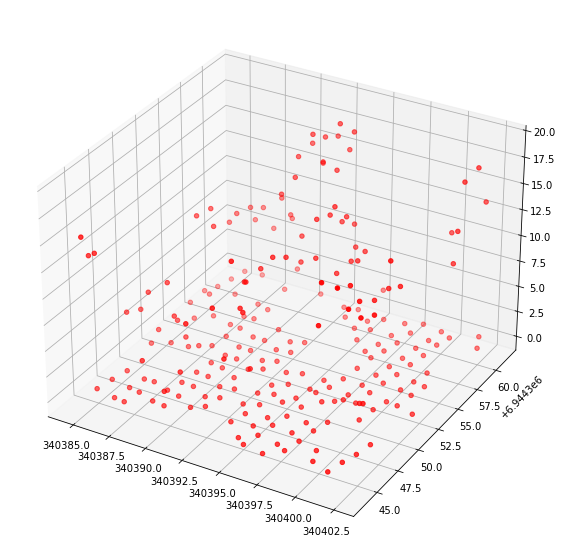

In [ ]:
points = data.points.copy()
las_scaleX = data.header.scale[0]
las_scaleY = data.header.scale[1]
las_scaleZ = data.header.scale[2]
las_offsetX = data.header.offset[0]
las_offsetY = data.header.offset[1]
las_offsetZ = data.header.offset[2]

p_X = np.array((points['point']['X'] * las_scaleX) + las_offsetX)
p_Y = np.array((points['point']['Y'] * las_scaleY) + las_offsetY)
p_Z = np.array((points['point']['Z'] * las_scaleZ) + las_offsetZ)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p_X, p_Y, p_Z, c='r', marker='o')
plt.show()

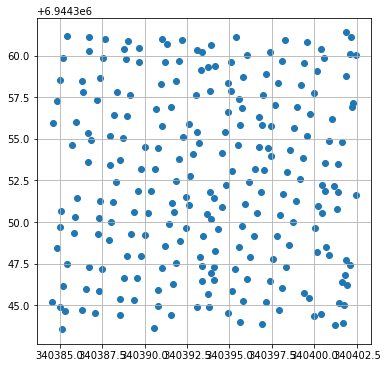

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.scatter(p_X, p_Y)
plt.grid()

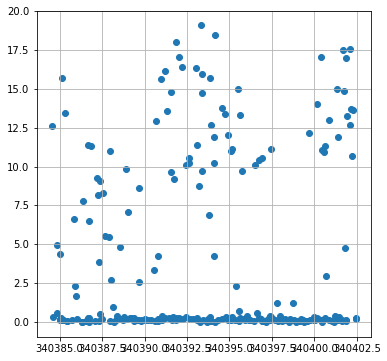

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.scatter(p_X, p_Z)
plt.grid()

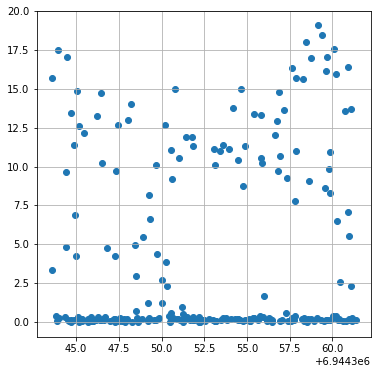

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.scatter(p_Y, p_Z)
plt.grid()

In [ ]:
lidar_df = las_to_df(str(data_path/example))
lidar_df.shape

(240, 5)

In [ ]:
lidar_df = field_plot_circular(lidar_df, ref_plot.x, ref_plot.y, 9)
lidar_df.shape

(189, 5)

In [ ]:
ref_plot

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,v_lp,myear,filename_1,a_date_1,a_window_1,filename_2,a_date_2,a_window_2
1010,914098,340393.5,6944352.47,2013,13.0,18.4,14.2,91.46,52.76,31.2,7.51,2013,/wrk/project_ogiir-csc/mml/laserkeilaus/2008_1...,2013-07-27,C,NaN,NaN,NaN


In [ ]:
np.array((ref_plot.x, ref_plot.y), (ref_plot.x, ref_plot.y))

array([[ 340393.5 ],
       [6944352.47]])

In [ ]:
np.array([lidar_df.iloc[0].x, lidar_df.iloc[0].y])

array([ 340401.66, 6944343.95])

In [ ]:
np.linalg.norm(np.array([lidar_df.iloc[0].x, lidar_df.iloc[0].y]).T - np.array([ref_plot.x, ref_plot.y]).T)

11.797287823602275

In [ ]:
np.sqrt((lidar_df.iloc[0].x - ref_plot.x)**2 + (lidar_df.iloc[0].y - ref_plot.y)**2)

1010    11.797288
dtype: float64

In [ ]:
ref_plot.x

1010    340393.5
Name: x, dtype: float64

In [ ]:
lidar_df['in_circle'] = lidar_df.apply(lambda row: 1 if np.linalg.norm(np.array([row.x, row.y]).T - np.array([ref_plot.x, ref_plot.y]).T) <= 9
                                       else 0, axis=1)

In [ ]:
lidar_df.in_circle.value_counts()

1    189
0     51
Name: in_circle, dtype: int64

In [ ]:
new_cols = ['hmax', 'hmean', 'hstd', 'pene', 'cv', 'imax', 'imean', 'imedian',
            'h10', 'h20', 'h30', 'h40', 'h50', 'h60', 'h70', 'h80', 'h90', 'h95', 'h98', 'h99',
            'p10', 'p20', 'p30', 'p40', 'p50', 'p60', 'p70', 'p80', 'p90', 'p95', 'p98', 'p99', 'p_no']

In [ ]:
calc_metrics(lidar_df)

[19.076,
 10.81275,
 4.396893838954323,
 0.36666666666666664,
 0.40663973910007384,
 3.0,
 1.2840909090909092,
 1.0,
 4.258,
 6.7434,
 9.1962,
 10.237,
 11.092,
 12.0418,
 13.391,
 14.828400000000002,
 16.3343,
 17.353399999999997,
 18.107420000000005,
 18.533989999999996,
 0.06818181818181818,
 0.1590909090909091,
 0.20454545454545456,
 0.26136363636363635,
 0.4090909090909091,
 0.6022727272727273,
 0.7613636363636364,
 0.8295454545454546,
 0.9431818181818182,
 0.9772727272727273,
 0.9886363636363636,
 0.9886363636363636,
 88]

In [ ]:
reference_data.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,...,p40,p50,p60,p70,p80,p90,p95,p98,p99,p_no
0,901025,309548.34,6888459.98,2013,34.5,12.7,12.6,220.31,0.00,141.55,...,0.330049,0.527094,0.694581,0.857143,0.965517,0.985222,0.995074,0.995074,0.995074,203.0
1,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,...,0.223856,0.339869,0.545752,0.750000,0.934641,0.983660,0.995098,0.996732,0.998366,612.0
2,901035,313849.13,6888457.52,2013,48.6,33.9,24.7,539.48,49.17,78.37,...,0.161157,0.232782,0.358127,0.574380,0.803030,0.940771,0.987603,0.995868,0.998623,726.0
3,901037,314346.79,6888434.54,2013,32.2,19.2,18.6,295.26,0.00,202.92,...,0.191176,0.318627,0.475490,0.656863,0.818627,0.916667,0.960784,0.985294,0.990196,204.0
4,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,...,0.084906,0.169811,0.283019,0.452830,0.679245,0.886792,0.943396,0.971698,0.981132,106.0


In [ ]:
reference_data.columns

Index(['sampleplotid', 'x', 'y', 'measurementdate', 'g', 'd', 'h', 'v', 'v_ma',
       'v_ku', 'v_lp', 'hmax', 'hmean', 'hstd', 'pene', 'cv', 'imax', 'imean',
       'imedian', 'h10', 'h20', 'h30', 'h40', 'h50', 'h60', 'h70', 'h80',
       'h90', 'h95', 'h98', 'h99', 'p10', 'p20', 'p30', 'p40', 'p50', 'p60',
       'p70', 'p80', 'p90', 'p95', 'p98', 'p99', 'p_no'],
      dtype='object')

In [ ]:
reference_data = reference_data.drop(columns = ['myear', 'filename_1', 'a_date_1', 'a_window_1', 
                                                'filename_2', 'a_date_2', 'a_window_2'])


In [ ]:
def process_reference_data_lidar(fn:str, plot_x:float, plot_y:float, plot_radius:float=9):
    lidar_data = las_to_df(fn)
    lidar_data = field_plot_circular(lidar_data, plot_x, plot_y, plot_radius)
    metrics = calc_metrics(lidar_data)
    return metrics

In [ ]:
reference_data[new_cols] = reference_data.apply(lambda row: process_reference_data_lidar(str(data_path/str(int(row.sampleplotid)))+'.las', row.x, row.y, 9),
                                                            axis=1, result_type='expand')

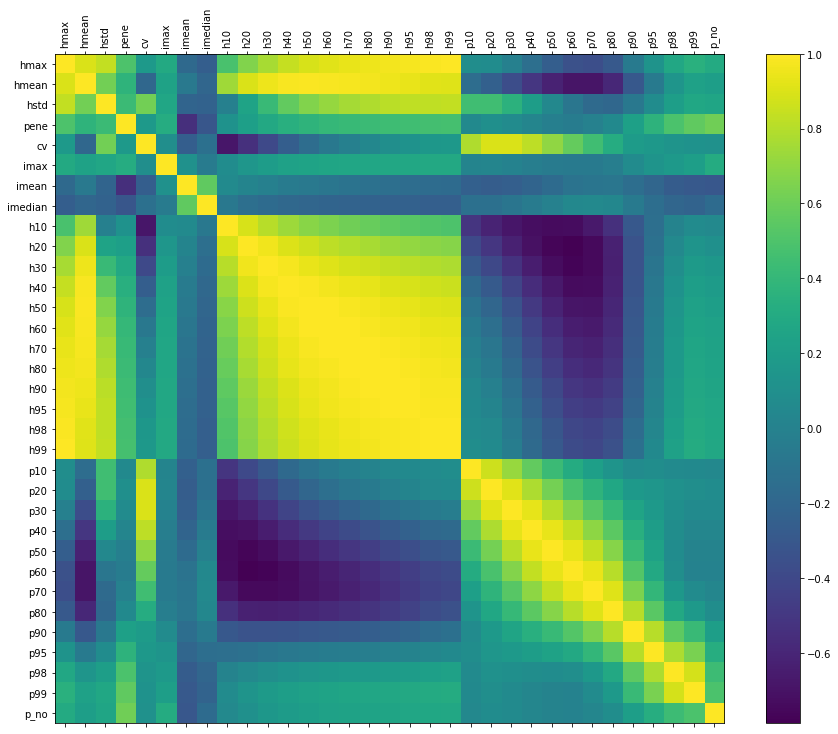

In [ ]:
fig = plt.figure(figsize=(15,12))
plt.matshow(reference_data[new_cols].corr(), fignum=fig.number)
plt.xticks(ticks=range(len(new_cols)), labels=new_cols, rotation=90)
plt.yticks(ticks=range(len(new_cols)), labels=new_cols)
cb = plt.colorbar()
plt.show()

In [ ]:
reference_data.pene.describe()

count    1494.000000
mean        0.497545
std         0.169890
min         0.028571
25%         0.381286
50%         0.495025
75%         0.611584
max         0.971264
Name: pene, dtype: float64

In [ ]:
reference_data.pene.describe()

count    1494.000000
mean        0.496669
std         0.167092
min         0.026786
25%         0.384302
50%         0.495858
75%         0.606009
max         0.964789
Name: pene, dtype: float64